In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

In [4]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from sklearn.metrics.pairwise import cosine_similarity

# Load SOAP fingerprint and Gibbs free energy Data 

In [5]:
data = pd.read_hdf('C_353VALID_SOAP_h5_v4.dat')

In [6]:
data['phaseId'] = data['phaseId'].astype(str)
data = data.sample(frac=1, random_state=111)
data.head()

,T,P,G,phaseId,poscar_frame,0,1,2,3,4,...,97,98,99,100,101,102,103,104,valid,dG
43281,900.0,62.5,-6.772181,434,0.0,0.212639,-1.533873,2.671043,-12.650208,25.388548,...,0.817456,-0.000896,0.789538,-1.492545,0.102469,3.567107,-3.051374,16.870098,1.0,0.998462
37148,3000.0,750.0,-5.242983,369,0.0,0.204900,-1.512760,2.569087,-12.872248,25.876547,...,0.613902,3.194426,1.021027,-1.031991,-5.216081,1.217153,4.348073,33.693455,1.0,0.898080
66942,1260.0,875.0,-4.082847,734,0.0,0.253041,-1.722096,3.214688,-15.032146,29.710289,...,0.757890,0.055794,0.726643,-1.399377,0.172783,3.254513,-3.333404,20.790129,1.0,1.079790
3073,2160.0,62.5,-7.733930,41,0.0,0.302562,-1.922355,3.992342,-16.324902,34.153088,...,0.466011,1.304004,0.694802,-0.837344,-2.331111,1.208955,2.537967,9.539306,1.0,0.396877
78495,1620.0,937.5,-3.716346,848,0.0,0.414320,-2.323045,5.642503,-19.846195,42.238007,...,0.419726,0.051068,0.220376,-0.798717,-0.147736,3.535598,1.031680,1.302100,1.0,1.342774


In [7]:
# Clean un-coverged DFT phase data
rm_phases = ['75','374','485','547','982','429','788']

for ph in rm_phases:
    data = data.loc[~(data['phaseId']==ph)]

In [8]:
len(data), data['phaseId'].nunique()

(81360, 323)

In [9]:
index = (data['T']==0.0) & (data['P']==0.0)
data.loc[:,'T'] = data.loc[:,'T']/data['T'].max()
data.loc[:,'P'] = data.loc[:,'P']/data['P'].max()

ori_data = data.copy(deep=True)

p0t0_data = data[index]

index = (data['phaseId']=='diamond') | (data['phaseId']=='graphite')
gd_data = data[index]

data = data[data['valid']==1]

len(data),len(p0t0_data),len(gd_data)

(81360, 304, 576)

# User Inputs

In [10]:
fit_column = ['G']
add_p0t0_data = 0
add_gd_data = 0

savemodel=0
seed=0
phase_data_split = 1

nph = 275
ntest = 30

EPOCHS = 500
patience = 50
BATCHSIZE = 2048


Gshifts = [0, 0.025, 0.05]

normalize = 1

checkpoint_path = "models/"
checkpoint_dir = os.path.dirname(checkpoint_path)

must_train_phases = ['diamond', 'graphite','hex','237','353','111','159']
must_test_phases = ['291','132','677','127']

In [11]:
rm_columns = ['G','valid','dG', 'fitG', 'fit_coeff','poscar_frame']

data = data[[c for c in data if c not in rm_columns] + fit_column]
p0t0_data = p0t0_data[[c for c in data if c not in rm_columns] + fit_column]
gd_data = gd_data[[c for c in data if c not in rm_columns] + fit_column]

data.head()

,T,P,phaseId,0,1,2,3,4,5,6,...,96,97,98,99,100,101,102,103,104,G
43281,0.30,0.066667,434,0.212639,-1.533873,2.671043,-12.650208,25.388548,-53.703793,11.094016,...,-0.439179,0.817456,-0.000896,0.789538,-1.492545,0.102469,3.567107,-3.051374,16.870098,-6.772181
37148,1.00,0.800000,369,0.204900,-1.512760,2.569087,-12.872248,25.876547,-54.112698,11.195869,...,-0.615668,0.613902,3.194426,1.021027,-1.031991,-5.216081,1.217153,4.348073,33.693455,-5.242983
66942,0.42,0.933333,734,0.253041,-1.722096,3.214688,-15.032146,29.710289,-62.561382,11.739043,...,-0.403412,0.757890,0.055794,0.726643,-1.399377,0.172783,3.254513,-3.333404,20.790129,-4.082847
3073,0.72,0.066667,41,0.302562,-1.922355,3.992342,-16.324902,34.153088,-72.551720,12.213844,...,-0.384015,0.466011,1.304004,0.694802,-0.837344,-2.331111,1.208955,2.537967,9.539306,-7.733930
78495,0.54,1.000000,848,0.414320,-2.323045,5.642503,-19.846195,42.238007,-90.987808,13.040316,...,-0.118502,0.419726,0.051068,0.220376,-0.798717,-0.147736,3.535598,1.031680,1.302100,-3.716346


In [12]:
def get_phDiagram(data, Gshift=None, rm_phases=[], Gcolumn='G'):
    """
    Function to generate phase diagram given prediction dataframe
    """

    filter_data = data[~data['phaseId'].isin(rm_phases)]
    
    phDig_data = []
    
    for p in data['P'].unique():
        for t in data['T'].unique():
            index = (filter_data['P']==p) & (filter_data['T']==t)

            # Equilibrium Phase
            d = filter_data.loc[index].sort_values(by=[Gcolumn])
            ref_ph = d['phaseId'].values[0]
            ref_G = d[Gcolumn].values[0]

            # Metastable Phase at Gshift
            if Gshift is not None:
                dshift = d.loc[(d[Gcolumn] - ref_G - Gshift) <= 0]
                ref_ph = dshift['phaseId'].values[-1]
                ref_G = dshift[Gcolumn].values[-1]

            phDig_ = {'T': t, 'P': p,'phaseId': ref_ph, 'refG': ref_G}

            phDig_data.append(phDig_)
            
    phDig_data = pd.DataFrame(phDig_data)
    return phDig_data

In [13]:
def plot_parity(tr_pred, tr_y, test_pred, test_y, savefigure=0, fname='parity_ntr.png'):
    """
    Function to generate parity plot to check ML model performance
    """

        # Variable for plotting
        fs=13
        msize=40
        xlim=500

        tr_error = tr_y - tr_pred
        test_error = test_y - test_pred
        tr_rmse = np.sqrt(np.average(np.square(tr_error)))
        test_rmse = np.sqrt(np.average(np.square(test_error)))

        tr_mae = np.mean(np.abs(tr_error))
        test_mae = np.mean(np.abs(test_error))

        
        fig,ax1 = plt.subplots(nrows=1, ncols=1, facecolor='white',figsize=(4,3))
        ax1.scatter(test_y,test_pred,marker='o',label='Test',s = msize,facecolors='none', edgecolors='b')
        ax1.scatter(tr_y,tr_pred,marker='s',label='Train',s = msize,facecolors='none', edgecolors='r')
        #ax1.plot([-4000,xlim],[-4000,xlim],'--k')

        #ax1.text(0.05,0.8,'RMSE: %.2f'%test_rmse,ha='left',transform=ax1.transAxes)
        #ax1.text(0.05,0.7,'Tr_RMSE: %.2f'%tr_rmse,ha='left',transform=ax1.transAxes)

        ax1.text(0.05,0.8,'MAE: %.2f'%test_mae,ha='left',transform=ax1.transAxes)
        ax1.text(0.05,0.7,'Tr_MAE: %.2f'%tr_mae,ha='left',transform=ax1.transAxes)

        
        ax1.set_xlabel('E DFT (meV/atom)', fontsize=fs)
        ax1.set_ylabel('ML Prediction (meV/atom)', fontsize=fs)

        ax1.text(0.05,0.9,'ML',ha='left',transform=ax1.transAxes)
        ax1.text(0.05,0.6,'Ntrain: %s'%len(tr_y),ha='left',transform=ax1.transAxes)
        ax1.text(0.05,0.5,'Ntest: %s'%len(test_y),ha='left',transform=ax1.transAxes)

        ax1.legend(ncol=1,frameon=False,loc=4)

        plt.tight_layout()

        if(savefigure==1):
            plt.savefig(fname,dpi=300,bbox_inches='tight')
            plt.close()

        else:
            plt.show()

In [14]:
def visualize_phase(data, phaseIds=['cubic'], oriColumnName='G'):
    """
    Function to generate Gibbs energy variation diagram to check ML model performance
    """

  
  fig, axs = plt.subplots(2,3, sharex=True, sharey=True, figsize=(15,12))
  axs = axs.ravel()

  for i, phaseId in enumerate(phaseIds):

    d = data.loc[data['phaseId']==phaseId]
    d = d.sort_values(by=['P','T'])

    for p in d['P'].unique()[::2]:
        #plt.plot(d.loc[d['P']==p,'T'],d.loc[d['P']==p,'fitG'],'-sk')
        axs[i].plot(d.loc[d['P']==p,'T'],d.loc[d['P']==p,oriColumnName],'-o')
        axs[i].plot(d.loc[d['P']==p,'T'],d.loc[d['P']==p,'pred'],'-vm')
    axs[i].set_title(phaseId)

  plt.show()

In [15]:
def get_phCols():
    """
    Function to assign unique colors to phases
    """

    
    col_data = pd.DataFrame()
    col_data['phaseId'] = ori_data['phaseId'].unique()
    col_data['col'] = 'k'

    col_data.loc[col_data['phaseId']=='132','col'] = 'darkorange'
    col_data.loc[col_data['phaseId']=='319','col'] = 'orange'    
    col_data.loc[col_data['phaseId']=='237','col'] = 'darkgoldenrod'
    col_data.loc[col_data['phaseId']=='228','col'] = 'c'
    col_data.loc[col_data['phaseId']=='291','col'] = 'gray'
    col_data.loc[col_data['phaseId']=='353','col'] = '#3d1772'
    col_data.loc[col_data['phaseId']=='20','col'] = '#612f14'
    col_data.loc[col_data['phaseId']=='diamond','col'] = 'r'
    col_data.loc[col_data['phaseId']=='graphite','col'] = '#65e12a'
    col_data.loc[col_data['phaseId']=='hex','col'] = '#155c1a'
    
    return col_data

col_data = get_phCols()

In [16]:
def get_trainValTesPhases(data, nph, must_train_phases, ntest, must_test_phases, random_sel=False):

  all_phases = data['phaseId'].unique()

  if random_sel:
    # Random Phase selection
    sel_phs = np.random.choice(all_phases, size=nph, replace=False)


  # Diverse Phase selection
  else:
    X_cols = data.drop(columns=['phaseId']+fit_column).columns
    std = data[X_cols].std(axis=0)
    X_cols = X_cols.drop(X_cols[std == 0])

    phase_fp_data = data.drop_duplicates(['phaseId'])[X_cols.union(['phaseId'])]
    phase_fp_data = phase_fp_data.reset_index(drop=True)

    fps = phase_fp_data[X_cols]
    nfps = len(fps)

    def distij(i,j,fps=fps):
        return (1 - cosine_similarity(fps.loc[i].values.reshape(1, -1), fps.loc[j].values.reshape(1, -1)))[0,0]

    picker = MaxMinPicker()
    pickIndices = picker.LazyPick(distij,nfps,nph,seed=1121)    
    sel_phs = phase_fp_data.loc[list(pickIndices), 'phaseId']
    
    
  for ph in must_train_phases:
    if np.sum(sel_phs == ph):
      continue
    else:
      sel_phs = np.append(sel_phs,ph)
      print('Added ' + ph + ' to Train Set')

  sel_phs = np.setdiff1d(sel_phs, must_test_phases)
  


  remain_phases = np.setdiff1d(all_phases, sel_phs)
  test_phs = np.random.choice(remain_phases, size=ntest, replace=False)

  for ph in must_test_phases:
    if np.sum(test_phs == ph):
      continue
    else:
      test_phs = np.append(test_phs,ph)
      print('Added ' + ph + ' to Test Set')

  valid_phases = np.setdiff1d(remain_phases, test_phs)

  return sel_phs, valid_phases, test_phs

# Split test, train, validation data

In [17]:
if phase_data_split:
    print('Spliting test train data based on phaseID')
    sel_phs, valid_phases, test_phs = get_trainValTesPhases(data, nph, must_train_phases, ntest, must_test_phases)
    print(sel_phs.shape, valid_phases.shape, test_phs.shape)

    sel_phs_data = data.loc[data['phaseId'].isin(sel_phs)]

    if add_p0t0_data:
        sel_phs_data = pd.concat([sel_phs_data, p0t0_data])

    if add_gd_data:
        sel_phs_data = pd.concat([sel_phs_data, gd_data])

        
    valid_phs_data = data.loc[data['phaseId'].isin(valid_phases)]
    test_phs_data = data.loc[data['phaseId'].isin(test_phs)]

    
    X_cols = sel_phs_data.drop(columns=['phaseId']+fit_column).columns

    std = sel_phs_data[X_cols].std(axis=0)
    X_cols = X_cols.drop(X_cols[std == 0])

    tr_x, tr_y = (sel_phs_data[X_cols].values, sel_phs_data[fit_column[0]].values)

    test_x = test_phs_data[X_cols].values
    test_y = test_phs_data[fit_column[0]].values

    valid_x = valid_phs_data[X_cols].values
    valid_y = valid_phs_data[fit_column[0]].values

else:

    X_cols = data.drop(columns=['phaseId']+fit_column).columns

    std = data[X_cols].std(axis=0)
    X_cols = X_cols.drop(X_cols[std == 0])

    tr_x, tr_y = data[X_cols].values[:int(len(data)*0.8)], data[fit_column].values[:int(len(data)*0.8)]
    valid_x, valid_y = data[X_cols].values[int(len(data)*0.8) : int(len(data)*0.9)], data[fit_column].values[int(len(data)*0.8) : int(len(data)*0.9)]
    test_x, test_y = data[X_cols].values[int(len(data)*0.9):], data[fit_column].values[int(len(data)*0.9):]

Spliting test train data based on phaseID
Added 237 to Train Set
Added 127 to Test Set
(273,) (19,) (31,)


In [18]:
tr_x = tr_x.astype('float32')
tr_y = tr_y.astype('float32')

test_x = test_x.astype('float32')
test_y = test_y.astype('float32')

valid_x = valid_x.astype('float32')
valid_y = valid_y.astype('float32')

tr_y = tr_y.flatten()
valid_y = valid_y.flatten()
test_y = test_y.flatten()

print(tr_x.shape, test_x.shape, valid_x.shape)

(67608, 107) (8568, 107) (5184, 107)


# Normalize Input data

In [19]:
if normalize:
    
  print("Normalizing feature vector")    
  mean = tr_x.mean(axis=0)
  tr_x -= mean

  std = tr_x.std(axis=0)
  tr_x /= std

  valid_x -= mean
  valid_x /= std

  test_x -= mean
  test_x /= std

Normalizing feature vector


# Define NN Model

In [393]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[len(tr_x[0])]),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
        
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    
    # Start new layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),    
    # End new layers
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(32, activation='relu'),

    
    tf.keras.layers.Dense(1)
])

In [552]:
optimizer = tf.keras.optimizers.Adam(0.00005)
e = 'mae'

model.compile(loss='%s'%e,
            optimizer=optimizer,
            metrics=['%s'%e])

In [553]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               13824     
_________________________________________________________________
dense_21 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_22 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)              

In [554]:
checkpoint_path = 'models/ckpt'
patience = 50
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,
                                                 min_lr=0.000005, verbose=1)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 mode='min',
                                                 verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)

early_history = model.fit(tr_x, tr_y,
                          epochs=EPOCHS,
                          validation_data = (valid_x,valid_y),
                          verbose=1,
                          batch_size=BATCHSIZE,
                          callbacks=[reduce_lr,cp_callback,early_stop])

Train on 67608 samples, validate on 5184 samples
Epoch 1/500
61440/67608 [==========================>...] - ETA: 0s - loss: 0.0659 - mae: 0.0659
Epoch 00001: val_loss improved from inf to 0.05624, saving model to models/v7/ckpt
67608/67608 [==============================] - 2s 34us/sample - loss: 0.0672 - mae: 0.0672 - val_loss: 0.0562 - val_mae: 0.0562
Epoch 2/500
63488/67608 [===========================>..] - ETA: 0s - loss: 0.0620 - mae: 0.0620
Epoch 00002: val_loss did not improve from 0.05624
67608/67608 [==============================] - 0s 6us/sample - loss: 0.0621 - mae: 0.0621 - val_loss: 0.0600 - val_mae: 0.0600
Epoch 3/500
63488/67608 [===========================>..] - ETA: 0s - loss: 0.0624 - mae: 0.0624
Epoch 00003: val_loss did not improve from 0.05624
67608/67608 [==============================] - 0s 7us/sample - loss: 0.0627 - mae: 0.0627 - val_loss: 0.0673 - val_mae: 0.0673
Epoch 4/500
65536/67608 [============================>.] - ETA: 0s - loss: 0.0636 - mae: 0.0636


Epoch 30/500
67584/67608 [============================>.] - ETA: 0s - loss: 0.0589 - mae: 0.0589
Epoch 00030: val_loss did not improve from 0.04804
67608/67608 [==============================] - 0s 7us/sample - loss: 0.0590 - mae: 0.0590 - val_loss: 0.0586 - val_mae: 0.0586
Epoch 31/500
67584/67608 [============================>.] - ETA: 0s - loss: 0.0595 - mae: 0.0595
Epoch 00031: val_loss did not improve from 0.04804
67608/67608 [==============================] - 0s 7us/sample - loss: 0.0596 - mae: 0.0596 - val_loss: 0.0547 - val_mae: 0.0547
Epoch 32/500
67584/67608 [============================>.] - ETA: 0s - loss: 0.0577 - mae: 0.0577
Epoch 00032: val_loss did not improve from 0.04804
67608/67608 [==============================] - 0s 7us/sample - loss: 0.0578 - mae: 0.0578 - val_loss: 0.0656 - val_mae: 0.0656
Epoch 33/500
61440/67608 [==========================>...] - ETA: 0s - loss: 0.0599 - mae: 0.0599
Epoch 00033: val_loss did not improve from 0.04804
67608/67608 [==============

Epoch 59/500
63488/67608 [===========================>..] - ETA: 0s - loss: 0.0558 - mae: 0.0558
Epoch 00059: val_loss did not improve from 0.04804
67608/67608 [==============================] - 0s 7us/sample - loss: 0.0561 - mae: 0.0561 - val_loss: 0.0531 - val_mae: 0.0531
Epoch 60/500
59392/67608 [=========================>....] - ETA: 0s - loss: 0.0560 - mae: 0.0560
Epoch 00060: val_loss did not improve from 0.04804
67608/67608 [==============================] - 0s 7us/sample - loss: 0.0563 - mae: 0.0563 - val_loss: 0.0514 - val_mae: 0.0514
Epoch 61/500
61440/67608 [==========================>...] - ETA: 0s - loss: 0.0552 - mae: 0.0552
Epoch 00061: val_loss did not improve from 0.04804
67608/67608 [==============================] - 0s 7us/sample - loss: 0.0554 - mae: 0.0554 - val_loss: 0.0504 - val_mae: 0.0504
Epoch 62/500
61440/67608 [==========================>...] - ETA: 0s - loss: 0.0548 - mae: 0.0548
Epoch 00062: val_loss did not improve from 0.04804
67608/67608 [==============

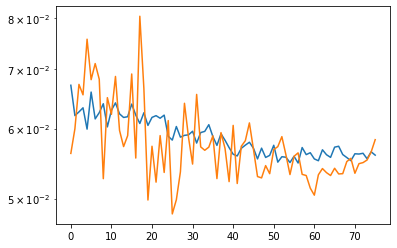

In [555]:
plt.plot(early_history.history['%s'%e])
plt.plot(early_history.history['val_%s'%e])

plt.yscale('log')

# Load best trained model

In [556]:
model.load_weights(checkpoint_path)

In [557]:
tr_pred = model.predict(tr_x).reshape(len(tr_x))
val_pred = model.predict(valid_x).reshape(len(valid_x))
test_pred = model.predict(test_x).reshape(len(test_x))

In [558]:
tr_y.shape, valid_y.shape, test_y.shape

((67608,), (5184,), (8568,))

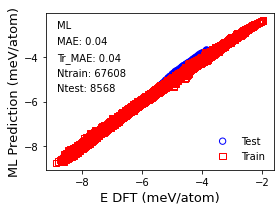

In [559]:
plot_parity(tr_pred, tr_y.flatten(), test_pred, test_y.flatten(),savefigure = 0)

In [560]:
print('MAE')
np.mean(np.abs(tr_y - tr_pred)), np.mean(np.abs(val_pred - valid_y)), np.mean(np.abs(test_pred - test_y))

MAE


(0.03931738, 0.048035502, 0.03714854)

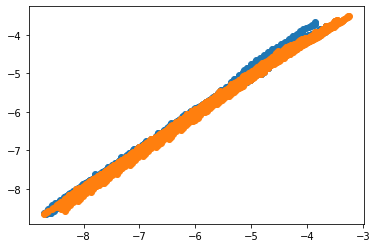

In [561]:
#plt.scatter(tr_y, tr_pred)
plt.scatter(test_y, test_pred)
plt.scatter(valid_y, val_pred)

In [562]:
if normalize:
  print('Normalize feature vector')    
  pred = model.predict((ori_data[X_cols] - mean)/std)
else:
  pred = model.predict(ori_data[X_cols])

Normalize feature vector


In [563]:
ori_data['pred'] = pred

# Visualize individual phase prediction

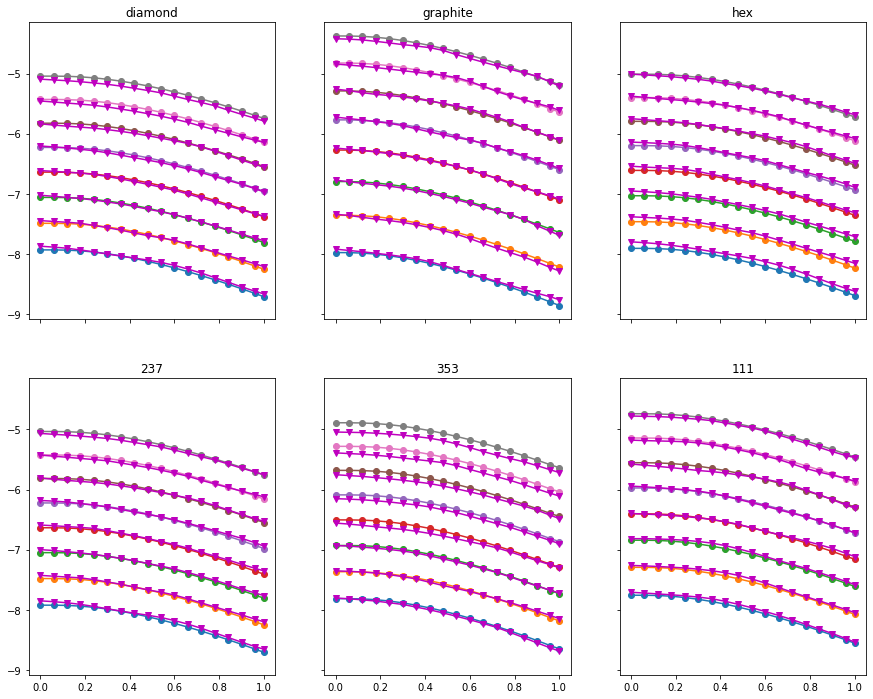

In [564]:
visualize_phase(ori_data.loc[ori_data['valid']==1],
                phaseIds=['diamond', 'graphite','hex','237','353','111'], oriColumnName=fit_column[0])

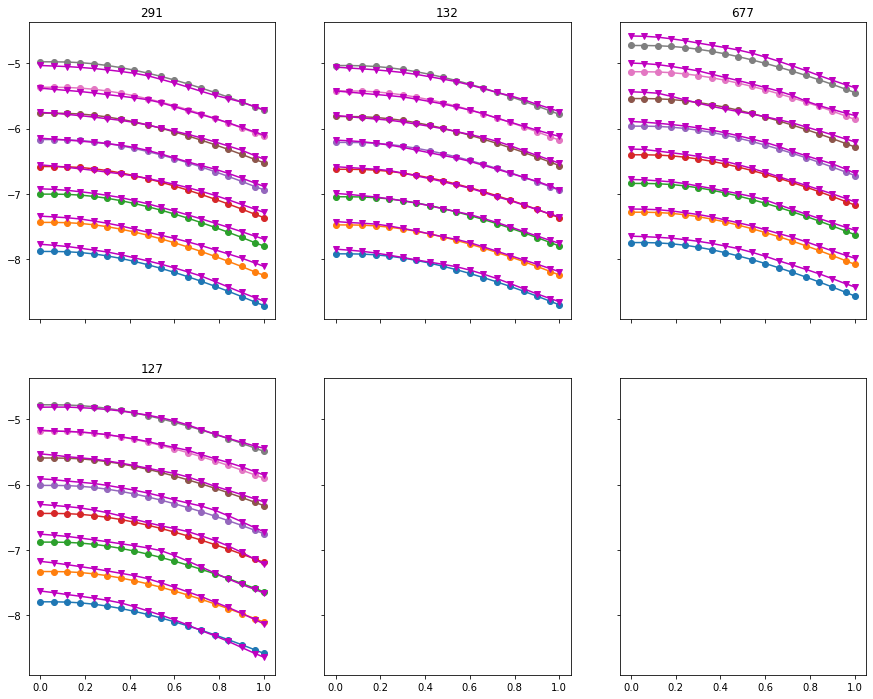

In [565]:
visualize_phase(ori_data.loc[ori_data['valid']==1],
                phaseIds=['291','132','677','127'], oriColumnName=fit_column[0])

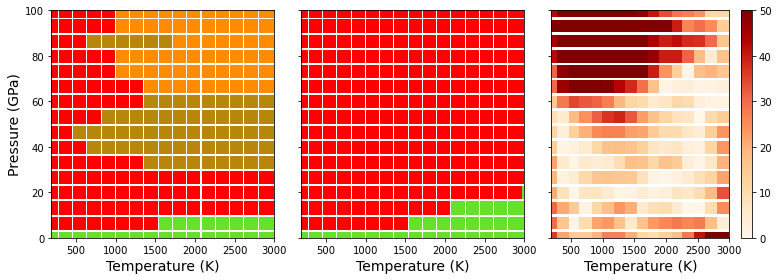

In [569]:
saveplot = 0
Gshifts = [0]
imp_pahses = ['diamond','132','237','graphite', '319', 'hex']

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(11,4), sharex=True, sharey=True)

for i,Gshift in enumerate(Gshifts):

    # Ax1
    phDig_data = get_phDiagram(ori_data, Gshift=Gshift, Gcolumn='G')
    phDig_data = phDig_data.merge(col_data, on='phaseId', how='left')
    
    ori_phDig_data = get_phDiagram(ori_data, Gshift=Gshift, Gcolumn=fit_column[0])
    phDig_data['Error'] = np.abs(ori_phDig_data['refG'] - phDig_data['refG'])

    ax1.scatter(phDig_data['T'], phDig_data['P'], c=phDig_data['col'], s=150, marker='s')
    ax1.set_xlim([0.0625,1])
    ax1.set_ylim([0,1])

    ax1.set_xticks([1/6,2/6,3/6,4/6,5/6,1])
    ax1.set_xticklabels([500,1000,1500,2000,2500,3000])

    ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax1.set_yticklabels([0,20,40,60,80,100])

    ax1.set_xlabel('Temperature (K)', fontsize=14)
    ax1.set_ylabel('Pressure (GPa)', fontsize=14)



    # Ax2
    phDig_data = get_phDiagram(ori_data, Gshift=Gshift, Gcolumn='pred')
    #phDig_data.loc[~phDig_data['phaseId'].isin(imp_pahses), 'phaseId'] = 'graphite'

    phDig_data = phDig_data.merge(col_data, on='phaseId', how='left')
    
    ori_phDig_data = get_phDiagram(ori_data, Gshift=Gshift, Gcolumn=fit_column[0])
    phDig_data['Error'] = np.abs(ori_phDig_data['refG'] - phDig_data['refG'])

    ax2.scatter(phDig_data['T'], phDig_data['P'], c=phDig_data['col'], s=150, marker='s')
    ax2.set_xlim([0.0625,1])
    ax2.set_ylim([0,1])

    ax2.set_xticks([1/6,2/6,3/6,4/6,5/6,1])
    ax2.set_xticklabels([500,1000,1500,2000,2500,3000])

    ax2.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax2.set_yticklabels([0,20,40,60,80,100])

    ax2.set_xlabel('Temperature (K)', fontsize=14)
    #ax2.set_ylabel('Pressure (GPa)', fontsize=14)
        

        #Ax3
    cbar = ax3.scatter(phDig_data['T'], phDig_data['P'], c=phDig_data['Error']*1000, s=130, cmap='OrRd',
                         vmin=0, vmax=50, marker='s')
    ax3.set_xlim([0.0625,1])
    ax3.set_ylim([0,1])

    ax3.set_xticks([1/6,2/6,3/6,4/6,5/6,1])
    ax3.set_xticklabels([500,1000,1500,2000,2500,3000])

    ax3.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax3.set_yticklabels([0,20,40,60,80,100])

    ax3.set_xlabel('Temperature (K)', fontsize=14)
    #ax3.set_ylabel('Pressure (GPa)', fontsize=14)


    fig.colorbar(cbar, ax=ax3)

plt.tight_layout()

if(saveplot==1):
    plt.savefig('C_phase_dig_pred.png',bbox_inches='tight',dpi=400)
plt.show()

# Publication Plots

In [599]:
import matplotlib.pyplot as plt

from matplotlib import rc
from matplotlib import rcParams

rcParams['font.sans-serif'] = "Arial Narrow"
rcParams['font.family'] = "sans-serif"

rcParams['axes.linewidth'] = 0.5

rc('text', usetex=False)
rc('xtick', labelsize=13) 
rc('ytick', labelsize=13) 

rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3.5
rcParams['ytick.minor.size'] = 3.5

/home/rbatra/anaconda3/envs/potential/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/rbatra/anaconda3/envs/potential/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


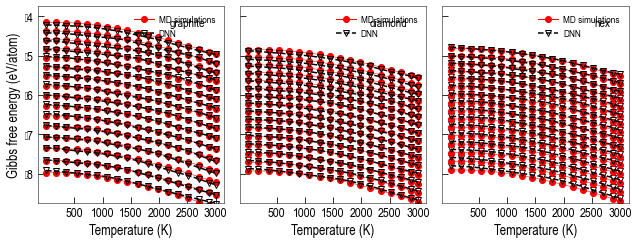

In [601]:
saveplot=0
version=1

phaseIds=['graphite','diamond','hex']

xymin, xymax = (-8.75,-3.75)

fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(9,3.5))
axs = axs.ravel()

for i, phaseId in enumerate(phaseIds):

  d = ori_data.loc[data['phaseId']==phaseId]
  d = d.sort_values(by=['P','T'])

  for p in d['P'].unique():
      axs[i].plot(d.loc[d['P']==p,'T'],d.loc[d['P']==p,'G'],'-o', color='r', lw=0.5)
      axs[i].plot(d.loc[d['P']==p,'T'],d.loc[d['P']==p,'pred'],'--v', markerfacecolor='None', color='k')
  axs[i].text(0.9,0.9,phaseId, transform=axs[i].transAxes, ha='right', fontsize=12)

  axs[i].set_xticks([1/6,2/6,3/6,4/6,5/6,1])
  axs[i].set_xticklabels([500,1000,1500,2000,2500,3000])

  axs[i].set_xlabel('Temperature (K)', fontsize=14)

  axs[i].plot([],[],'-o', color='r', lw=1, label='MD simulations')
  axs[i].plot([],[],'--v', markerfacecolor='None', color='k', label='DNN')
  axs[i].legend(frameon=False, handletextpad=0.5)

axs[0].set_ylabel('Gibbs free energy (eV/atom)', fontsize=14)
axs[0].set_ylim(xymin, xymax)

plt.tight_layout()

if(saveplot==1):
    plt.savefig('figures/GvsT_v%s.pdf'%version,bbox_inches='tight',dpi=300)
plt.show()